# Imports

In [73]:
%load_ext autoreload
%autoreload 2
%run nnn/ipynb_init.py
%matplotlib inline
import nupack
from sklearn.model_selection import train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 640x480 with 0 Axes>

# Data prep

## Basic filtering

QC filtering and removing control constructs that do not have hairpin melting behaviors.

Clean up data for model training.

### arr_v0

Only basic curve fitting QC, no 2 state filter or $T_m$ dynamic range filter. 

This version was not used in the paper, but was still kept for accounting purposes and for consistency with historical analysis.

86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
64.31% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
71.46% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
Load from file ./data/fitted_variant/NNNlib2b_DNA_20211022_v6.CPvariant.gz
86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
Load from file ./data/fitted_variant/NNNlib2b_DNA_20211216_v9.CPvariant.gz
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5

Combining dH

Combining Tm

Combining dG_37

Combining dS

Combining fmax

Combining fmin
(30750, 42)


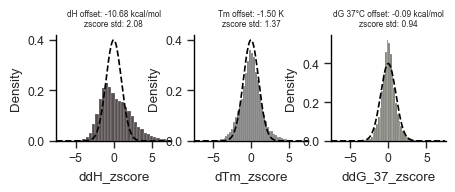

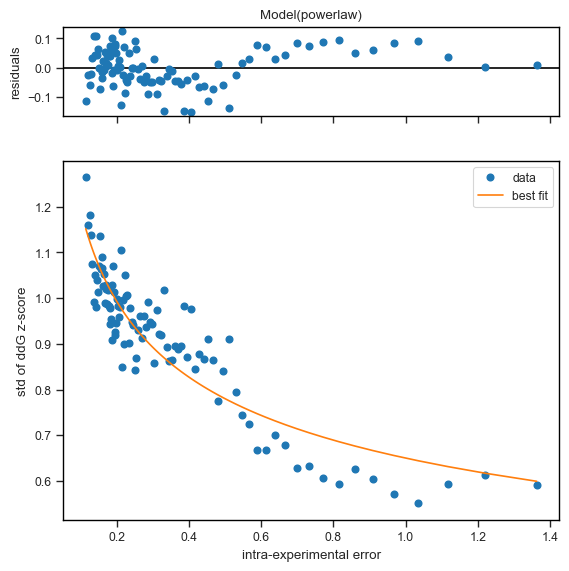

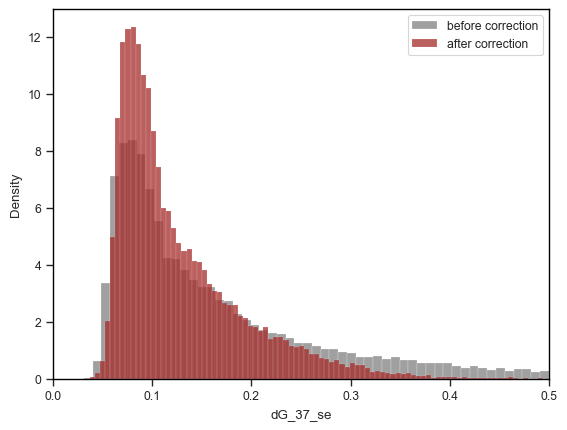

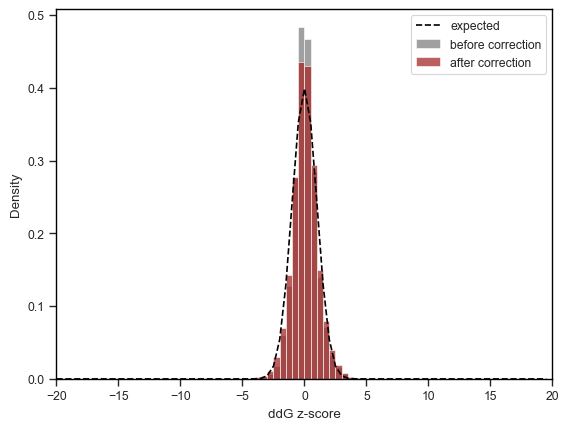

In [21]:
annotation_file = './data/annotation/NNNlib2b_annotation_2024_duplicates_dropped.tsv'
annotation = fileio.read_annotation(annotation_file)
replicate_df = pd.read_table('./data/nnnlib2b_replicates.tsv')
arraydata = ArrayData(replicate_df=replicate_df.iloc[:4,:],
                      annotation_file=annotation_file,
                      learn_error_adjust_from=('r1', 'r2'))
arr = arraydata.data.join(arraydata.annotation)

# removing control constructs that do not have hairpin melting behavior
excluded_construct_type = ['pseudoknot_pt_muts', 'PolyNTControls', 'RepeatControls', 'StemDangle_3p', 'StemDangle_53p', 'StemDangle_5p', 'PUMcontrols']
arr = arr[arr.reset_index().ConstructType.apply(lambda s: s not in excluded_construct_type).values]
arr = arr.dropna(subset=['ConstructType', 'RefSeq','TargetStruct'])

print(arr.shape)
arr.to_csv(os.path.join('./data/models/raw', 'arr_v0_n=%d.csv' % arr.shape[0]))

### arr_v1

With (relaxed) 2-state filter & variant-level Tm filter.

**Input:**

- `./data/nnnlib2b_replicates.tsv`

- `./data/annotation/NNNlib2b_annotation_2024.tsv`



In [85]:
annotation_file = './data/annotation/NNNlib2b_annotation_2024_duplicates_dropped.tsv'
annotation = fileio.read_annotation(annotation_file, sodium=0.063)
replicate_df = pd.read_table('./data/nnnlib2b_replicates.tsv')

print('\nReading Array Melt replicate data...\n')
arraydata = ArrayData(replicate_df=replicate_df.iloc[:4,:],
                    annotation_file=annotation_file)

print('\n\nFiltering two state variants...\n')
myfilter = "dH_err_rel < 0.5 & Tm_err_abs < 10 & redchi < 2 & n_inlier > 8"
pass_df = arraydata.filter_two_state(min_rep_pass=1, force_recalculate=False, overwrite_dH=False, 
                                     inplace=True, myfilter=myfilter, plot_fig=False)

print('\n\nRemoving extra control series...\n')
arr = arraydata.data.join(arraydata.annotation)
excluded_construct_type = ['pseudoknot_pt_muts', 'PolyNTControls', 'RepeatControls', 'StemDangle_3p', 'StemDangle_53p', 'StemDangle_5p', 'PUMcontrols', 'WBcontrols']
arr = arr[arr.reset_index().ConstructType.apply(lambda s: s not in excluded_construct_type).values]
# Remove pseudoknots without annotation
arr = arr.dropna(subset=['ConstructType', 'RefSeq','TargetStruct'])
print('%d variants left.' % arr.shape[0])

print('\n\nFiltering Tm in range...\n')
variant_filter = 'Tm < 60 & Tm > 0'
arr_in_range = arr.query(variant_filter)
print('%d/%d (%.2f%%) variants met the Tm in range criterion.' % 
        (len(arr_in_range), len(arr), len(arr_in_range)/len(arr)*100))
arr = arr_in_range

arr.to_csv(os.path.join('./data/models/raw', 'arr_v1_n=%d.csv' % arr.shape[0]))


Reading Array Melt replicate data...

86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
64.31% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
71.46% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5


Filtering two state variants...

86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
64.31% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
71.46% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5

30091/31000 (97.07%) variants passed the two state criteria.


Removing extra control series...

2986

- Show variant class accounting information:

In [71]:
arraydata.accounting_df.T

,designed,fitted,passed2state
Bulges,11520,9474,9408
Control,595,127,112
External,31,20,20
MisMatches,18240,11366,11086
TETRAloop,6144,5749,5465
TRIloop,1536,1454,1402
VARloop,172,7,5
WatsonCrick,3072,2680,2479


- Show number of variants in each subclass (construct type)

In [86]:
ctype, counts = np.unique(arr_in_range.ConstructType, return_counts=True)
dict(zip(ctype, counts))

{'3mer': 1890,
 'AC_mismatch_varpos': 2649,
 'BaeControls': 17,
 'Centered': 2691,
 'GT_mismatch_varpos': 3495,
 'NN': 975,
 'NNN': 4884,
 'NNN_3primebulge': 4260,
 'NNN_5prime_bulge': 4233,
 'NN_3primebulge': 304,
 'NN_5primebulge': 300,
 'VARloop': 5,
 'WC_5ntstem': 760,
 'WC_6ntstem': 682,
 'WC_7ntstem': 585}

## Basic preprocessing

### Adjust offset

In [12]:
arr = pd.read_csv('./data/models/raw/arr_v1_n=27732.csv', index_col=0)


297 / 387 single curves passed QC




(-4.0, 0.0)

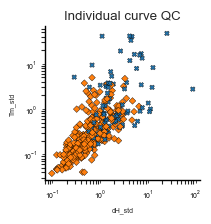

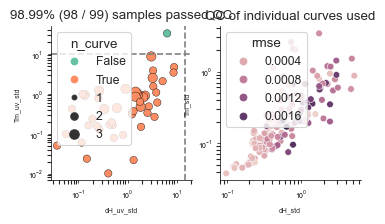

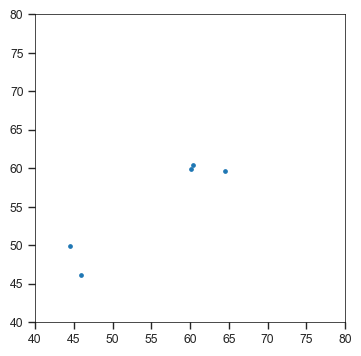

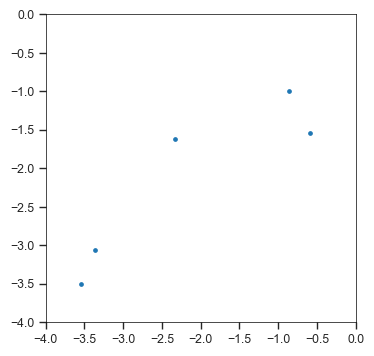

In [13]:
"""
Get the offset the violent way
"""
# copy pasted from command center for convenience
# only one peak found by AnalyzePeaks
hplc_clean_seqid = ["WC68_stem_3p", "WC68_stem_5p", "WC1025_split_5p", \
"WC1025_split_3p", "WC1375_stem_5p", "WC1375_stem_3p", "DMM004_5p", \
"DMM004_3p", "DMM005_5p", "DMM005_3p", "DMM006_5p", "DMM007_5p", \
"DMM007_3p", "BC0", "BC1", "BC6", "BC7", "BC8", "BC9", "BC10", \
"BC11", "MMCNNN2328", "MMCNNN2331", "MMCNNN2334", "MMCNNN2335", \
"MMCNNN2336", "MMCNNN2337", "MMTM1325", "MMTM176", "MMTM178", \
"MMTM179", "MMTM181", "MMTM185", "MMTM189", "MMTM1917", "MMTM29", \
"MMTM397", "MMTM509", "MMTM877", "DMM003_3p_rc", "DMM004_3p_rc", \
"DMM005_3p_rc", "DMM006_3p_rc", "DMM007_3p_rc", "TETNN1003", \
"TETNN999", "TETNN963", "TETNN979", "TETNNN1696", "TETNNN2082", \
"TETNNN1570", "HP002", "HP003", "HP004", "HP005", "HP007", "HP008", \
"HP010", "HP011", "HP012", "HP014", "HP015", "HP016", "HP017", \
"HP018", "HP019", "HP021", "HP022", "HP023", "HP024"]

sample_sheet_file = './data/uv_melt/ECLTables/ECLSampleSheet230502.csv'
datadir="./data/uv_melt/ECLExportAuto"
result_file='./data/uv_melt/uvmelt_230502_2.csv'
agg_result_file='./data/uv_melt/uvmelt_agg_230502.csv'

result_df = pd.read_csv(result_file, index_col=0)
result_agg_df = uv.agg_fit_result(uvmelt_result_file=result_file,
                               agg_result_file=agg_result_file,
                               single_curve_qc_criteria='rmse < 0.002 & dH_std < 10 & Tm_std < 5 & dH < 0 & dH > -100 & Tm > 0 & Tm < 120',
                               Tm_std_thresh=10, dH_std_thresh=15,
                               sample_sheet_file=sample_sheet_file, 
                               clean=True, only_use_cooling=True)

result_agg_df = result_agg_df[result_agg_df.SEQID.isin(hplc_clean_seqid)]

vf = result_agg_df.query('is_hairpin & Na_mM == 25').sort_values(by=['conc_uM', 'n_curve', 'curve_date']).drop_duplicates(keep='last').merge(arr, how='left', on='SEQID')

df_q = vf.dropna(subset=['Tm', 'dG_37'])#.query(plot_query)
df_q.dG_37_uv_std = 0

dTm = np.median(df_q.Tm_uv - df_q.Tm)
df_q['Tm_adj'] = df_q.Tm + dTm
df_q['dG_37_adj'] = util.get_dG(dH=df_q.dH, Tm=df_q.Tm_adj, celsius=37)

plt.figure(figsize=(4,4))
plt.plot(df_q.Tm_uv, df_q.Tm_adj, '.')
lim = [40,80]
plt.xlim(lim)
plt.ylim(lim)

plt.figure(figsize=(4,4))
plt.plot(df_q.dG_37_uv, df_q.dG_37_adj, '.')
lim = [-4,0]
plt.xlim(lim)
plt.ylim(lim)

In [14]:
def adjust_offset(dH, Tm, dTm):
    Tm_adj = Tm + dTm
    dG_37_adj = util.get_dG(dH=dH, Tm=Tm_adj, celsius=37)
    dS_adj = dH / (Tm_adj + 273.15)
    return dict(dH=dH, dS=dS_adj, Tm=Tm_adj, dG_37=dG_37_adj)

cols = ['dH_se', 'Tm_se', 'dG_37_se', 'dS_se', 'RefSeq', 'TargetStruct', 'Series']
arr_adj = pd.DataFrame(adjust_offset(arr.dH, arr.Tm, dTm))
arr_adj[cols] = arr[cols]

arr_adj.to_csv(os.path.join('./data/models/processed', 'arr_v1_adjusted_n=%d.csv' % arr_adj.shape[0]))

In [15]:
dTm

9.348410006623254

In [16]:
dG_median = util.get_dG(dH=np.median(arr.dH), Tm=np.median(arr.Tm), celsius=37)
dG_adj_median = util.get_dG(dH=np.median(arr.dH), Tm=np.median(arr.Tm) + dTm, celsius=37)
print('%.2f -> %.2f kcal/mol, ddG = %.2f kcal/mol' % (dG_median, dG_adj_median, dG_adj_median - dG_median))

-0.20 -> -0.92 kcal/mol, ddG = -0.71 kcal/mol


In [17]:
np.median(arr.dH) * (1 - (37 + 273.15) / (np.median(arr.Tm)))

168.76668749849256

### Salt correct array data to 1M Na+

`arr_adj` -> `arr_1M`

In [18]:
%%time
param_names = ['dH','dS','Tm', 'dG_37']
arr_1M = pd.DataFrame(index=arr_adj.index, columns=param_names)

for i, row in arr_adj.iterrows():
    param_name_dict = util.get_Na_adjusted_param(Na=1.0, from_Na=0.063, dH=row.dH, Tm=row.Tm, seq=row.RefSeq)
    arr_1M.loc[i,:] = param_name_dict

arr_1M[cols] = arr[cols]

# remove dangles
# they should have been removed already but just in case
sd_mask = arr_1M.apply(lambda row: not row.name.startswith('SD'), axis=1)
arr_1M = arr_1M[sd_mask.values]

arr_1M.to_csv('./data/models/processed/arr_v1_1M_63mM_n=%d.csv'%arr_1M.shape[0])

CPU times: user 5.54 s, sys: 126 ms, total: 5.66 s
Wall time: 5.63 s


### Same for arr_v0

In [27]:
arr = pd.read_csv('./data/models/raw/arr_v0_n=30872.csv', index_col=0)

In [28]:
cols = ['dH_se', 'Tm_se', 'dG_37_se', 'dS_se', 'RefSeq', 'TargetStruct', 'Series']
arr_adj = pd.DataFrame(adjust_offset(arr.dH, arr.Tm, dTm))
arr_adj[cols] = arr[cols]

arr_adj.to_csv(os.path.join('./data/models/processed', 'arr_v0_adjusted_n=%d.csv' % arr_adj.shape[0]))

In [29]:
%%time
param_names = ['dH','dS','Tm', 'dG_37']
arr_1M = pd.DataFrame(index=arr_adj.index, columns=param_names)

for i, row in arr_adj.iterrows():
    param_name_dict = util.get_Na_adjusted_param(Na=1.0,dH=row.dH, Tm=row.Tm, seq=row.RefSeq)
    arr_1M.loc[i,:] = param_name_dict

arr_1M[cols] = arr[cols]

# remove dangles
# they should have been removed already but just in case
sd_mask = arr_1M.apply(lambda row: not row.name.startswith('SD'), axis=1)
arr_1M = arr_1M[sd_mask.values]

arr_1M.to_csv('./data/models/processed/arr_v0_1M_n=%d.csv'%arr_1M.shape[0])

CPU times: user 6.22 s, sys: 60.9 ms, total: 6.28 s
Wall time: 6.31 s


## Rude preprocessing

### Original to 1M Na+

`arr -> arr_1M`

In [6]:
arr = pd.read_csv('./data/models/raw/arr_v1_n=27732.csv', index_col=0)

In [11]:
%%time
param_names = ['dH','dS','Tm', 'dG_37']
arr_1M = pd.DataFrame(index=arr.index, columns=param_names)

for i, row in arr.iterrows():
    param_name_dict = util.get_Na_adjusted_param(Na=1.0, from_Na=0.088, dH=row.dH, Tm=row.Tm, seq=row.RefSeq)
    arr_1M.loc[i,:] = param_name_dict

cols = ['dH_se', 'Tm_se', 'dG_37_se', 'dS_se', 'RefSeq', 'TargetStruct', 'Series']
arr_1M[cols] = arr[cols]

# remove dangles
# they should have been removed already but just in case
sd_mask = arr_1M.apply(lambda row: not row.name.startswith('SD'), axis=1)
arr_1M = arr_1M[sd_mask.values]

arr_1M.to_csv('./data/models/processed/arr_v2_1M_88mM_n=%d.csv'%arr_1M.shape[0])
print('n=%d'%arr_1M.shape[0])

n=27732
CPU times: user 5.49 s, sys: 99.7 ms, total: 5.59 s
Wall time: 5.53 s


### Adjust offset w.r.t. NUPACK (maybe slightly circular)

`arr_1M -> arr_1M_adj`

Only use training data for adjustment.

In [13]:
arr_1M = pd.read_csv('./data/models/processed/arr_v2_1M_n=27732.csv', index_col=0)
data_split_dict = fileio.read_json('./data/models/raw/data_split.json')

In [14]:
arr_1M_train = arr_1M.loc[[x for x in arr_1M.index if x in data_split_dict['train_ind']]]

arr_1M_train = arr_1M_train.join(arr[['ConstructType', 'dG_37_NUPACK', 'Tm_NUPACK']])

<Axes: xlabel='ddG_37', ylabel='Density'>

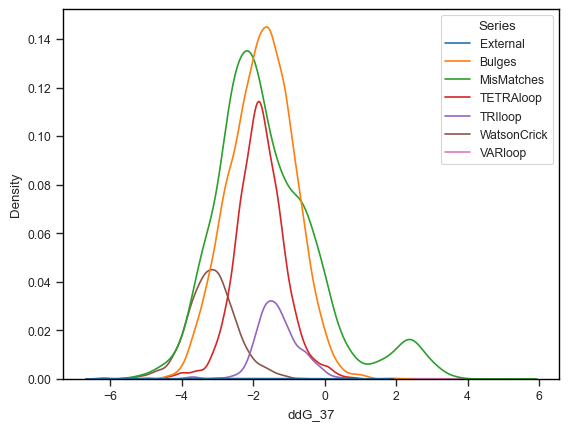

In [15]:
arr_1M_train['ddG_37'] = arr_1M_train.dG_37_NUPACK - arr_1M_train.dG_37
sns.kdeplot(data=arr_1M_train, x='ddG_37', hue='Series')

<Axes: xlabel='dTm', ylabel='Density'>

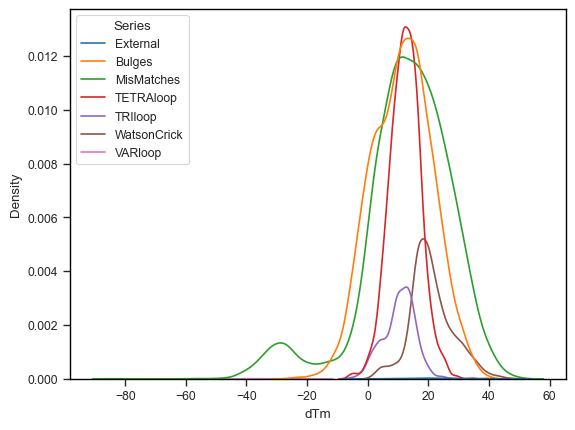

In [16]:
arr_1M_train['dTm'] = arr_1M_train.Tm_NUPACK - arr_1M_train.Tm
sns.kdeplot(data=arr_1M_train, x='dTm', hue='Series')

<Axes: xlabel='ddG_37', ylabel='Density'>

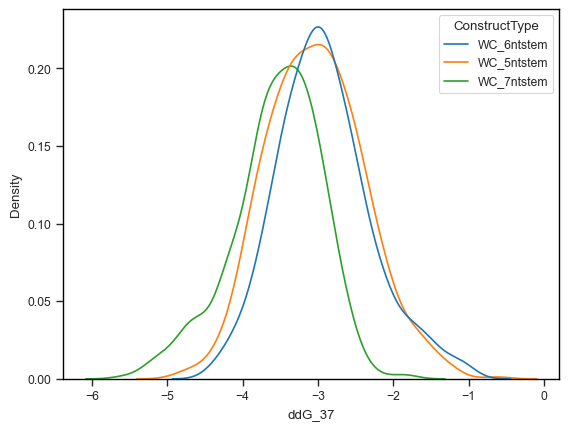

In [17]:
sns.kdeplot(data=arr_1M_train.query('Series == "WatsonCrick"'), x='ddG_37', hue='ConstructType')

In [18]:
dTm_by_series = arr_1M_train.groupby(['Series', 'ConstructType'])['dTm'].apply(np.median).fillna(value=0)
dTm_by_series

Series       ConstructType     
Bulges       NNN_3primebulge       10.005800
             NNN_5prime_bulge      12.147991
             NN_3primebulge        22.231302
             NN_5primebulge        22.455473
External     BaeControls           20.294685
             WBcontrols             0.000000
MisMatches   3mer                  11.585653
             AC_mismatch_varpos    26.345570
             Centered              17.193788
             GT_mismatch_varpos     6.527488
TETRAloop    NN                    16.742231
             NNN                   11.729666
TRIloop      NN                    15.616951
             NNN                   10.190561
VARloop      VARloop              -35.681387
WatsonCrick  WC_5ntstem            26.291553
             WC_6ntstem            19.304034
             WC_7ntstem            17.750857
Name: dTm, dtype: float64

In [19]:
arr_1M_train['Tm_adj'] = arr_1M_train.apply(lambda row: row.Tm + dTm_by_series[row['Series']][row['ConstructType']], axis=1)

In [20]:
arr_1M_train[['Tm', 'Tm_adj']]

,Tm,Tm_adj
SEQID,,
BC1,54.750994,75.045680
BC10,29.959820,50.254505
BC11,33.906068,54.200753
BC15,41.645712,61.940398
BC16,35.963347,56.258033
...,...,...
varloop257581,65.502814,29.821427
varloop257601,49.375317,13.693931
varloop257621,44.087860,8.406473


In [21]:
def recalculate(dH, Tm_adj):
    dG_37_adj = util.get_dG(dH=dH, Tm=Tm_adj, celsius=37)
    dS_adj = dH / (Tm_adj + 273.15)
    return dict(dH=dH, dS=dS_adj, Tm=Tm_adj, dG_37=dG_37_adj)

cols = ['dH_se', 'Tm_se', 'dG_37_se', 'dS_se', 'RefSeq', 'TargetStruct', 'Series']
arr_adj = pd.DataFrame(recalculate(arr_1M_train.dH, arr_1M_train.Tm_adj))
arr_adj[cols] = arr[cols]

arr_adj.to_csv(os.path.join('./data/models/processed', 'arr_v2_adjusted_n=%d.csv' % arr_adj.shape[0]))

## Update data split

Remove the variants measured by UV melting from the training set.

In [22]:
agg_result_file='./data/uv_melt/uvmelt_agg_230502.csv'
uv_df = pd.read_csv(agg_result_file, index_col=1)
arr_1M = pd.read_csv('./data/models/processed/arr_v1_1M_n=27732.csv', index_col=0)
arr_p_unfold = pd.read_csv('./data/models/raw/arr_p_unfold_n=31000.csv', index_col=0)


In [23]:
from sklearn.model_selection import train_test_split

ind2split = list(set(arr_1M.index) - set(uv_df.index))
series2split = arr_1M.loc[ind2split, 'Series']

train_val_ind, test_ind = train_test_split(ind2split, test_size=.05,
                                       random_state=42, stratify=series2split)
train_ind, val_ind = train_test_split(arr_1M.loc[train_val_ind,:].index, test_size=.05,
                                      random_state=43, stratify=arr_1M.loc[train_val_ind,:].Series)
test_ind += list(set(uv_df.index) & set(arr_1M.index))
n_train, n_val, n_test = len(train_ind), len(val_ind), len(test_ind)
print('train','val ','test')
print(n_train, n_val, n_test)

split_dict = dict(train_ind=train_ind.tolist(),
                  val_ind=val_ind.tolist(),
                  test_ind=test_ind)
with open('./data/models/raw/data_split.json', 'w') as fh:
    json.dump(split_dict, fh, indent=4)

additional_ind = list(set(arr_p_unfold.index) - set(arr_1M.index))

additional_train_val_ind, additional_test_ind = train_test_split(additional_ind, test_size=.1,
                                       random_state=44)
additional_train_ind, additional_val_ind = train_test_split(arr_p_unfold.loc[additional_train_val_ind,:].index.tolist(), test_size=.1,
                                      random_state=45)

split_dict['train_ind'] += additional_train_ind
split_dict['val_ind'] += additional_val_ind
split_dict['test_ind'] += additional_test_ind

fileio.write_json(split_dict, './data/models/raw/data_split_p_unfold.json')

train val  test
24979 1315 1438


## Other data prep

In [4]:
"""
ECL uv data cleaning
Reduced to HP only as the reset are already in the array dataset.
"""
from nnn import train_nn as tnn

mydata = tnn.MyData()
mydata.load_everything()

In [347]:
uv_agg_df = fileio.clean_uv_df(mydata.uv_df, mydata.ecl_oligo_df, mydata.annotation)
uv_agg_df = uv_agg_df.reset_index(names=['SEQID'])
uv_agg_df = uv_agg_df.loc[uv_agg_df.SEQID.apply(lambda x: x.startswith('HP'))]
uv_agg_df = uv_agg_df.set_index('SEQID')
uv_agg_df.to_csv('./data/models/raw/uv_n=%d.csv'%len(uv_agg_df))

val_ind, test_ind = train_test_split(np.unique(uv_agg_df.index), test_size=.5,
                                       random_state=42)

print('val ','test')
print(len(uv_agg_df.loc[val_ind]), len(uv_agg_df.loc[test_ind]))

split_dict = dict(
    train_ind=[],
    val_ind=val_ind.tolist(),
    test_ind=test_ind.tolist())
fileio.write_json(split_dict, './data/models/raw/data_split_uv.json')

val  test
6 6


In [348]:
sl_mm = pd.read_csv('./data/literature/SantaLucia_single_mismatch.csv', index_col=0)
sl_mm['isWC'] = sl_mm.dG_37.apply(lambda x: x == 'WC')
sl_wc = pd.read_csv('./data/literature/SantaLucia_full.tsv', sep='\t', index_col=0)

def add_wc(row):
    if row.dG_37 == 'WC':
        return float(sl_wc.loc[row.name, 'dG_37'])
    else:
        return float(row.dG_37)
    
sl_mm['dG_37'] = sl_mm.apply(add_wc, axis=1)
sl_mm.to_csv('./data/literature/SantaLucia_mm_wc.csv')

In [349]:
"""
Oliveira data split (OV)
"""
center_df = fileio.read_Oliveira_df('./data/literature/Oliveira_2020_mismatches.csv')

val_ind, test_ind = train_test_split(center_df.index, test_size=.5,
                                       random_state=42)

n_val, n_test = len(val_ind), len(test_ind)
print('val ','test')
print(n_val, n_test)

split_dict = dict(train_ind=[],
                  val_ind=val_ind.tolist(),
                  test_ind=test_ind.tolist())

with open('./data/models/raw/data_split_Oliveira.json', 'w') as fh:
    json.dump(split_dict, fh, indent=4)

val  test
1387 1388


In [350]:
"""
348oligos data split (DP) (lit_uv)
train:val:test = 0:1:1
"""
uv_df = pd.read_csv('./data/literature/compiled_DNA_Tm_348oligos.csv', index_col=0)

val_ind, test_ind = train_test_split(uv_df.index, test_size=.5,
                                       random_state=42)
train_ind = []
n_train, n_val, n_test = len(train_ind), len(val_ind), len(test_ind)
print('train', 'val ','test')
print(n_train, n_val, n_test)

split_dict = dict(
    train_ind=train_ind,
    val_ind=val_ind.tolist(),
    test_ind=test_ind.tolist())

with open('./data/models/raw/data_split_348oligos.json', 'w') as fh:
    json.dump(split_dict, fh, indent=4)

train val  test
0 174 174


## Clean up the variant annotation file

Clean up the annotation file:

- Drop duplicated variants

- Remove variants not really used for DNA experiment

- Unify SEQID to upper case

**Input:**

- `./data/annotation/NNNlib2b_annotation_20220519.tsv`


**Output:**

- `./data/annotation/NNNlib2b_annotation_2024.tsv`

- `./data/annotation/NNNlib2b_annotation_2024_duplicates_dropped.tsv`

In [67]:
# File names
annotation_file = './data/annotation/NNNlib2b_annotation_20220519.tsv'
new_annotation_file = './data/annotation/NNNlib2b_annotation_2024.tsv'

In [93]:
# Read in the 220519 annotation file
annotation = pd.read_table('./data/annotation/NNNlib2b_annotation_20220519.tsv', index_col=0)

# Unify all sequences to upper case
annotation['RefSeq'] = annotation.RefSeq.apply(lambda x: x.upper())

# Remove excessive (duplicated) VARloops
# annotation = annotation.loc[[seqid for seqid in annotation.index if not seqid.startswith('VAR')]]

# Remove pseudoknots and Pumillo RBP binding variants as they are for RNA and not really analyzed
annotation = annotation.query('ConstructType != "PUMcontrols" & ConstructType != "pseudoknots" & ConstructType != "pseudoknot_pt_muts"')

# Remove duplicated WBcontrols (only keep WB but not WB_controls...)
annotation.rename(index={'WB_controls260831':'WB7'}, inplace=True)
# annotation = annotation.loc[[seqid for seqid in annotation.index if (not seqid.startswith('WB')) or seqid.startswith('WB_')]]
annotation = annotation.loc[[seqid for seqid in annotation.index if (not seqid.startswith('WB')) or (not '_controls' in seqid)]]

# Save the new annotation file
annotation.to_csv(new_annotation_file, sep='\t')

In [92]:
annotation.rename(index={'WB_controls260831':'WB7'}, inplace=True)

In [94]:
# Print accounting numbers
print('\n~~~~~~~~~~Annotation file~~~~~~~~~~~\n')
print('\n============', 'TOTAL', '============')
print('All: %d\tUnique: %d' %
     (len(annotation), len(np.unique(annotation.RefSeq))))
for seq_class in np.unique(annotation.Series):
    print('\n============', seq_class, '============')
    print('All: %d\tUnique: %d' % 
          (len(annotation.query(f'Series == "{seq_class}"')), len(np.unique(annotation.query(f'Series == "{seq_class}"').RefSeq))))


~~~~~~~~~~Annotation file~~~~~~~~~~~


============ TOTAL ============
All: 41311	Unique: 40234

============ Bulges ============
All: 11520	Unique: 10880

============ Control ============
All: 595	Unique: 594

============ External ============
All: 32	Unique: 32

============ MisMatches ============
All: 18240	Unique: 17856

============ TETRAloop ============
All: 6144	Unique: 6144

============ TRIloop ============
All: 1536	Unique: 1536

============ VARloop ============
All: 172	Unique: 136

============ WatsonCrick ============
All: 3072	Unique: 3072


The annotation file `NNNlib2b_annotation_2024_duplicates_dropped.tsv` was made by dropping duplicates in `NNNlib2b_annotation_2024.tsv`.

In [38]:
annotation_file = './data/annotation/NNNlib2b_annotation_2024.tsv'
new_annotation_file = './data/annotation/NNNlib2b_annotation_2024_duplicates_dropped.tsv'
annotation = fileio.read_annotation(annotation_file)
annotation_unique = annotation.drop_duplicates(subset=['RefSeq'], keep='last')
annotation_unique.to_csv(new_annotation_file, sep='\t')

86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
64.31% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
71.46% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
Load from file ./data/fitted_variant/NNNlib2b_DNA_20211022_v6.CPvariant.gz
86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
Load from file ./data/fitted_variant/NNNlib2b_DNA_20211216_v9.CPvariant.gz
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5

Combining dH

Combining Tm

Combining dG_37

Combining dS

Combining fmax

Combining fmin


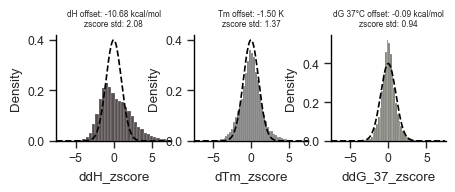

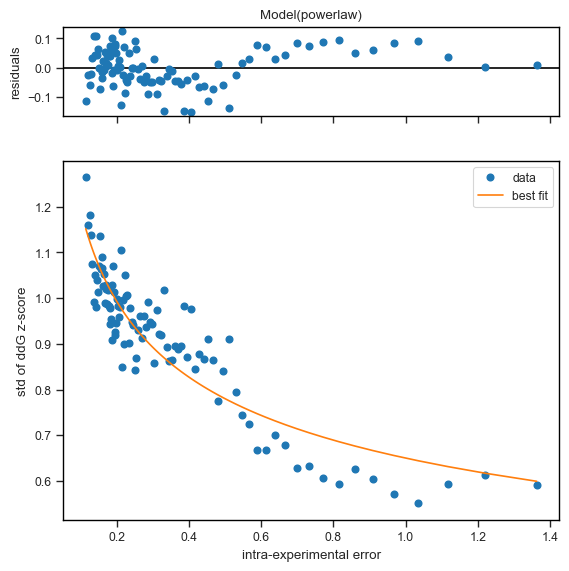

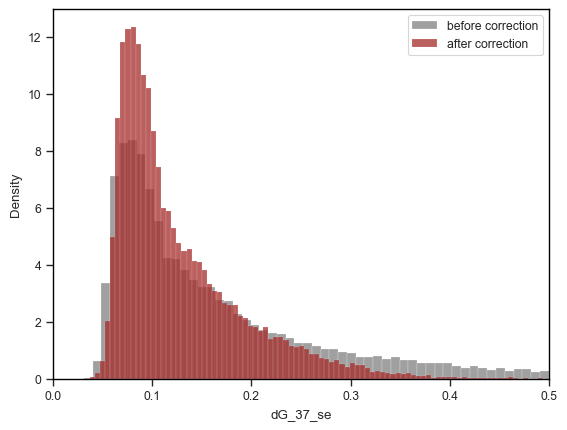

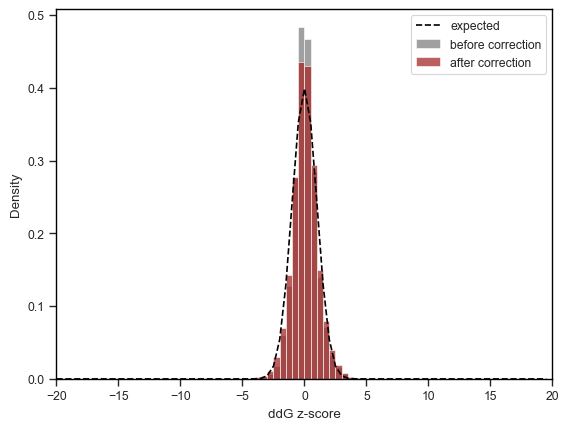

In [76]:
replicate_df = pd.read_table('./data/nnnlib2b_replicates.tsv')
arraydata = ArrayData(replicate_df=replicate_df.iloc[:4,:],
                      annotation_file=annotation_file,
                      learn_error_adjust_from=('r1', 'r2'))
arr = arraydata.data.join(arraydata.annotation)

In [74]:
'WB3' in arr.index.tolist(), 'WB_controls260871' in arr.index.tolist()

(True, False)

In [75]:
excluded_construct_type = ['pseudoknot_pt_muts', 'PolyNTControls', 'RepeatControls', 'StemDangle_3p', 'StemDangle_53p', 'StemDangle_5p', 'PUMcontrols']
arr_v0 = arr[arr.reset_index().ConstructType.apply(lambda s: s not in excluded_construct_type).values]
arr_v0 = arr_v0.dropna(subset=['ConstructType', 'RefSeq','TargetStruct'])
# arr_v0.rename(index={'WB3':'WB_controls260871'}, inplace=True)
print(arr_v0.shape)
arr_v0.to_csv(os.path.join('./data/models/raw', 'arr_v0_n=%d.csv' % arr_v0.shape[0]))

(30751, 42)


In [9]:
# Make the index in the data file compliant with the annotation file
arr_v0.rename(index={'WB3':'WB_controls260871'}, inplace=True)
arr_v1.rename(index={'WB3':'WB_controls260871'}, inplace=True)
arr_v1_1M.rename(index={'WB3':'WB_controls260871'}, inplace=True)

In [10]:
annotation.to_csv(new_annotation_file, sep='\t')
arr_v0.to_csv('./data/models/raw/arr_v0_n=30872.csv')
arr_v1.to_csv('./data/models/raw/arr_v1_n=27732.csv')
arr_v1_1M.to_csv('./data/models/processed/arr_v1_1M_n=27732.csv')

# Combining things

In [413]:
val_df, combined_split_dict = fileio.read_val_df('all')
val_df.to_csv('./data/models/raw/combined_dataset.csv')
fileio.write_json(combined_split_dict, './data/models/raw/combined_data_split.json')
print([len(inds) for inds in combined_split_dict.values()])

[24979, 2882, 3006]


In [417]:
df = fileio.load_val_df('./data/models/raw/combined_dataset.csv')

### SOME TESTS ###
# Check duplicates. Should be none.
assert len(df.loc[(df.index.duplicated())]) == 0

# Test indexing works 
for test_id in ['DP347', 'WC999', 'varloop257621', 'OV2679']:
    ind = np.searchsorted(df.index, [test_id])
    assert df.iloc[ind[0],:].name == test_id
    
### Save back ###
df.fillna(0, inplace=True)
df.to_csv('./data/models/raw/combined_dataset.csv')

# Tetraloops

In [23]:
def is_nnn_tetraloop(seq):
    flag = True
    
    if len(seq) != 16:
        flag = False
        
    if not seq.startswith('GATC'):
        flag = False
        
    return flag

my_df = mydata.annotation
rescue_df = my_df[my_df.RefSeq.apply(is_nnn_tetraloop)]
np.unique(my_df[my_df.RefSeq.apply(is_nnn_tetraloop)].Series)

array(['TETRAloop', 'VARloop', 'WatsonCrick'], dtype=object)

In [46]:
rescue_df.query('Series == "WatsonCrick"')

,Series,ConstructType,bottomScaffold,topScaffold,RefSeq,dH_NUPACK,dS_NUPACK,Tm_NUPACK,dG_37_ensemble_NUPACK,TargetStruct,dG_37_NUPACK,dG_37_ensemble_150mM_NUPACK,dG_37_ensemble_75mM_NUPACK
SEQID,,,,,,,,,,,,,
WC337,WatsonCrick,WC_6ntstem,GC,NaN,GATCAAGAAATTGATC,-43.8,-0.127906,69.289375,-4.408689,((((((....)))))),-4.13,-3.532474,-3.142028
WC340,WatsonCrick,WC_6ntstem,GC,NaN,GATCATGAAAATGATC,-42.3,-0.123456,69.481105,-4.289815,((((((....)))))),-4.01,-3.414562,-3.024805
WC343,WatsonCrick,WC_6ntstem,GC,NaN,GATCAGGAAACTGATC,-45.0,-0.129582,74.119221,-5.077725,((((((....)))))),-4.81,-4.194838,-3.800274
WC346,WatsonCrick,WC_6ntstem,GC,NaN,GATCACGAAAGTGATC,-46.7,-0.134548,73.938545,-5.236008,((((((....)))))),-4.97,-4.352368,-3.957440
WC349,WatsonCrick,WC_6ntstem,GC,NaN,GATCTAGAAATAGATC,-42.4,-0.125294,65.253500,-3.828455,((((((....)))))),-3.54,-2.961107,-2.577143
WC352,WatsonCrick,WC_6ntstem,GC,NaN,GATCTTGAAAAAGATC,-42.3,-0.123618,69.034272,-4.238612,((((((....)))))),-3.96,-3.363334,-2.973716
WC355,WatsonCrick,WC_6ntstem,GC,NaN,GATCTGGAAACAGATC,-45.0,-0.129582,74.119221,-5.076523,((((((....)))))),-4.81,-4.192852,-3.797847
WC358,WatsonCrick,WC_6ntstem,GC,NaN,GATCTCGAAAGAGATC,-45.8,-0.132645,72.131235,-4.928765,((((((....)))))),-4.66,-4.047904,-3.654557
WC361,WatsonCrick,WC_6ntstem,GC,NaN,GATCGAGAAATCGATC,-46.2,-0.132355,75.910414,-5.419805,((((((....)))))),-5.15,-4.535783,-4.140111


In [43]:
len(my_df.loc['TETNNN192', 'RefSeq'])

16

In [53]:
# either explicitly TETNNN or is in fact a TETNNN
rescue_seqid = np.unique(list(rescue_df.index) + [x for x in mydata.annotation.index if x.startswith('TETNNN')])

In [55]:
'WC337' in set(rescue_df.index)

True

In [64]:
fitted_single_variant_fn_list = ['./data/fitted_single_cluster/NNNlib2b_DNA_%s.CPvariant' % x 
                                 for x in ['20211022', '20211216', '20211221']]

with open(fitted_single_variant_fn_list[0], 'r') as fh:
    for line in fh:
        header = line
        break

outfile = './data/fitted_single_cluster/rescue.CPvariant'
if os.path.isfile(outfile):
    os.remove(outfile)
with open(outfile, 'a') as outfh:
    outfh.write(header)
    for fn in fitted_single_variant_fn_list:
        with open(fn, 'r') as fh:
            for line in fh:
                seqid = line.split('\t')[0]
                if seqid == 'WC337':
                    print('found!')
                if seqid in rescue_seqid:
                    outfh.write(line)

In [58]:
rescue_sc_df = pd.read_csv(outfile, sep='\t')

# rescue_sc_df = rescue_sc_df.query("rsqr > 0.5 & fmin_init > -1 & fmin_init < 2 & fmax_init > 0 & fmax_init < 2 & dH_init > -400")
# rescue_sc_df = rescue_sc_df.set_index('SEQID').join(mydata.annotation[['RefSeq']])
# rescue_sc_df = rescue_sc_df.groupby('SEQID').apply(np.mean)

# rescue_df = rescue_sc_df[['dH_init', 'Tm_init']]
# rescue_df.columns = ['dH', 'Tm']
# rescue_df.Tm = rescue_df.Tm - 273.15
# rescue_df['dG_37'] = util.get_dG(dH=rescue_df.dH, Tm=rescue_df.Tm, celsius=37)
# rescue_df = rescue_df.join(mydata.annotation[['RefSeq']])
# rescue_df['tetraloop'] = rescue_df.RefSeq.apply(lambda x: x[5:11])

In [61]:
rescue_df['tetraloop'] = rescue_df.RefSeq.apply(lambda x: x[5:11])

In [63]:
'WC337' in rescue_sc_df.index

False

In [18]:
'CGAAAG' in rescue_df.tetraloop.values

False

In [10]:
rescue_df

,dH,Tm,dG_37,RefSeq
SEQID,,,,
TETNNN0,-70.637718,27.610380,2.205282,GATCAAAAAATTGATC
TETNNN1,-45.088408,31.642404,0.792557,GATCAAAAATTTGATC
TETNNN10,-42.006303,35.483767,0.206365,GATCAAAACCTTGATC
TETNNN100,-58.045905,41.061653,-0.750330,GATCAATCTATTGATC
TETNNN1000,-89.413999,55.742603,-5.095436,GATCACGCCAGTGATC
...,...,...,...,...
TETNNN995,-62.012451,53.217764,-3.081503,GATCACGCAGGTGATC
TETNNN996,-99.543678,56.210875,-5.806158,GATCACGCTAGTGATC
TETNNN997,-49.938996,49.262384,-1.899341,GATCACGCTTGTGATC
